## Resources used

- [types of convolutions](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)


In [ ]:
from tensorflow import keras
from keras.datasets.mnist import load_data
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def get_fake_samples(n_samples: int):
    """sampling from a standard normal distribution"""
    X = np.random.randn(28 * 28 * n_samples).reshape(n_samples, 28, 28, 1)
    y = np.zeros(n_samples)
    return X, y

In [ ]:
class GAN:
    def __init__(self):
        self.image_shape = (28, 28, 1)
        self.latent_dim = 100
        self.data = self.load_mnist_data()

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss="binary_crossentropy", metrics=["accuracy"], optimizer=Adam(0.002, 0.5)
        )

        self.generator = self.build_generator(self.latent_dim, self.image_shape)

        noise = Input(shape=(self.latent_dim,))
        image = self.generator(noise)

        self.discriminator.trainable = False
        validity = self.discriminator(image)

        self.model = keras.Model(inputs=noise, outputs=validity, name="gan_mnist")
        self.model.compile(loss="binary_crossentropy", optimizer=Adam(0.002, 0.5))

    def build_discriminator(self):
        inputs = Input(shape=self.image_shape)
        conv_1 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
        activation_1 = LeakyReLU(0.2)(conv_1)
        norm_1 = BatchNormalization()(activation_1)

        conv_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(norm_1)
        activation_2 = LeakyReLU(0.2)(conv_2)
        norm_2 = BatchNormalization()(activation_2)

        conv_3 = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same")(norm_2)
        activation_3 = LeakyReLU(0.2)(conv_3)
        norm_3 = BatchNormalization()(activation_3)

        flatten_1 = Flatten()(norm_3)

        dense_4 = Dense(1, activation="sigmoid")(flatten_1)

        discriminator = keras.Model(
            inputs=inputs, outputs=dense_4, name="discriminator_mnist"
        )
        return discriminator

    def build_generator(self, latent_dim: int, image_shape: int):
        inputs = Input(shape=(latent_dim,))

        dense_1 = Dense(64)(inputs)
        activation_1 = LeakyReLU(0.2)(dense_1)
        norm_1 = BatchNormalization()(activation_1)

        dense_2 = Dense(128)(norm_1)
        activation_2 = LeakyReLU(0.2)(dense_2)
        norm_2 = BatchNormalization()(activation_2)

        dense_3 = Dense(128)(norm_2)
        activation_3 = LeakyReLU(0.2)(dense_3)
        norm_3 = BatchNormalization()(activation_3)

        dense_4 = Dense(784, activation="sigmoid")(norm_3)
        generated_image = Reshape(target_shape=image_shape)(dense_4)

        generator = keras.Model(
            inputs=inputs, outputs=generated_image, name="generator_mnist"
        )
        return generator

    def load_mnist_data(self):
        (trainX, _), (_, _) = load_data()
        X = np.expand_dims(trainX, axis=3)
        print(X.shape, X[0].shape)
        X = X.astype("float32")
        X = X / 255.0
        return X

    def generate_latent_points(self, n_samples: int):
        latent_vectors = np.random.randn(self.latent_dim * n_samples).reshape(
            (n_samples, self.latent_dim)
        )
        return latent_vectors

    def get_real_samples(self, n_samples: int):
        idx = np.random.randint(0, len(self.data), n_samples)
        X = self.data[idx]
        return X

    def generate_fake_samples(self, n_samples: int):
        noise = self.generate_latent_points(n_samples)
        X = self.generator.predict(noise)
        return X

    def train(self, epochs=250, batch_size=64, save_interval=50):
        half_batch = batch_size // 2
        y_real = np.ones(half_batch)
        y_fake = np.zeros(half_batch)

        for epoch in range(epochs):
            X_real = self.get_real_samples(half_batch)
            X_fake = self.generate_fake_samples(half_batch)

            d_loss_real = self.discriminator.train_on_batch(X_real, y_real)
            d_loss_fake = self.discriminator.train_on_batch(X_fake, y_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise_input = np.random.rand(half_batch, self.latent_dim)
            g_loss = self.model.train_on_batch(noise_input, y_real)

            print(epoch, d_loss[0], 100 * d_loss[1], g_loss)

            if epoch % save_interval == 0:
                self.show_images(epoch)

    def show_images(self, epoch):
        r, c = 5, 5
        noise = np.random.rand(r * c, self.latent_dim)
        generated_images = self.generator.predict(noise)

        fig, ax = plt.subplots(r, c)
        count = 0

        for i in range(r):
            for j in range(c):
                ax[i, j].imshow(generated_images[count, :, :, 0], cmap="gray_r")
                ax[i, j].axis("off")
        fig.savefig(f"epoch_{epoch}_result.png")
        plt.close()

In [ ]:
gan = GAN()
gan.train(epochs=8000, save_interval=1000)

1/1 [==============================] - 0s 19ms/step


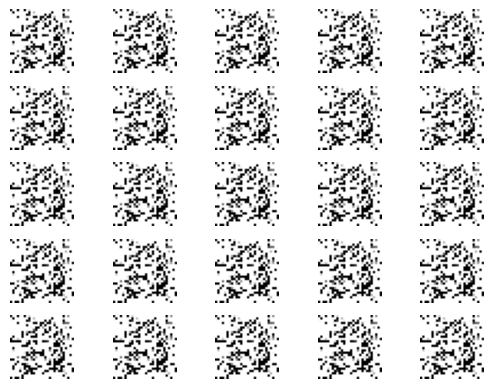

In [ ]:
r, c = 5, 5
noise = np.random.rand(r * c, 100)
generated_images = gan.generator.predict(noise)

fig, ax = plt.subplots(r, c)
count = 0

for i in range(r):
    for j in range(c):
        ax[i, j].imshow(generated_images[count, :, :, 0], cmap="gray_r")
        ax[i, j].axis("off")
fig.savefig(f"final_result.png")

In [ ]:
# latent_dim = 100

# def train(data, epochs = 200, batch_size = 128, save_interval = 40):
#     half_batch = batch_size // 2

#     for epoch in range(epochs):
#         # training loop
#         X_real, y_real = get_real_samples(data, half_batch)
#         X_fake, y_fake = generate_fake_samples(data, latent_dim, half_batch)

#         d_loss_real = discriminator.train_on_batch(X_real, y_real)
#         d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)

#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         X_gen, y_gen = generate_fake_samples(data, latent_dim, half_batch)